In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('uber_cleaned.csv')
df.rename(columns = {'pickup_longitude_x': 'pickup_longitude',
                     'pickup_latitude_x': 'pickup_latitude'}, inplace = True)
df.head()

,fare_id,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_rounded,...,haversine_distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek,pickup_dayofweek_label,fare_per_passenger,sublocality
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,40.738,...,1.683323,2015,5,7,19,52,3,Thursday,7.500000,Manhattan
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,40.728,...,2.457590,2009,7,17,20,4,4,Friday,7.700000,Manhattan
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,40.741,...,5.036377,2009,8,24,21,45,0,Monday,12.900000,Manhattan
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,40.791,...,1.661683,2009,6,26,8,22,4,Friday,1.766667,Manhattan
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,40.744,...,4.475450,2014,8,28,17,47,3,Thursday,3.200000,Queens


# Questions to answer:
## Business Performance
1. What are the peak demand hours/days?
2. Which locations generate highest revenue per trip?
3. How does fare vary by distance, time, and passenger count?

In [2]:
import plotly.express as px

# Count trips for each hour and day of week
heatmap_data = df.groupby(['pickup_dayofweek_label', 'pickup_hour']).size().reset_index(name='trip_count')

# Pivot for heatmap
heatmap_pivot = heatmap_data.pivot(index='pickup_dayofweek_label', columns='pickup_hour', values='trip_count')

# Plotly heatmap
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Pickup Hour", y="Day of Week", color="Trip Count"),
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    aspect="auto",
    title="Uber Trips Heatmap by Hour and Day of Week"
)
fig.show()

In [3]:
# Calculate total and average revenue per pickup location (rounded coordinates for grouping)
pickup_revenue = df.groupby(['sublocality']).agg(
    avg_revenue=('fare_amount', 'mean'),
    trip_count=('fare_amount', 'count')
).reset_index()

pickup_revenue.sort_values('avg_revenue', ascending=False).head(10)

,sublocality,avg_revenue,trip_count
3,Queens,29.337320,9661
5,Staten Island,17.382308,13
0,Brooklyn,12.953525,4414
1,Chauncey,12.900000,1
6,The Bronx,12.094585,205
2,Manhattan,10.213950,181151
4,Sobral,8.900000,1


In [9]:
import plotly.graph_objects as go

# Get top 10 locations for visualization
top_locations = pickup_revenue.sort_values('avg_revenue', ascending=False).head(10)

# Bar chart for average revenue
fig = go.Figure(data=[
    go.Bar(x=top_locations['sublocality'], 
           y=top_locations['avg_revenue'],
           marker_color='orange')
])

fig.update_layout(
    title='Average Revenue per Trip by Location',
    xaxis_title='Pickup Location',
    yaxis_title='Average Revenue ($)',
    xaxis_tickangle=45
)

fig.show()

In [5]:
df.columns

Index(['fare_id', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_latitude_rounded',
       'pickup_longitude_rounded', 'haversine_distance', 'pickup_year',
       'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_minute',
       'pickup_dayofweek', 'pickup_dayofweek_label', 'fare_per_passenger',
       'sublocality'],
      dtype='object')

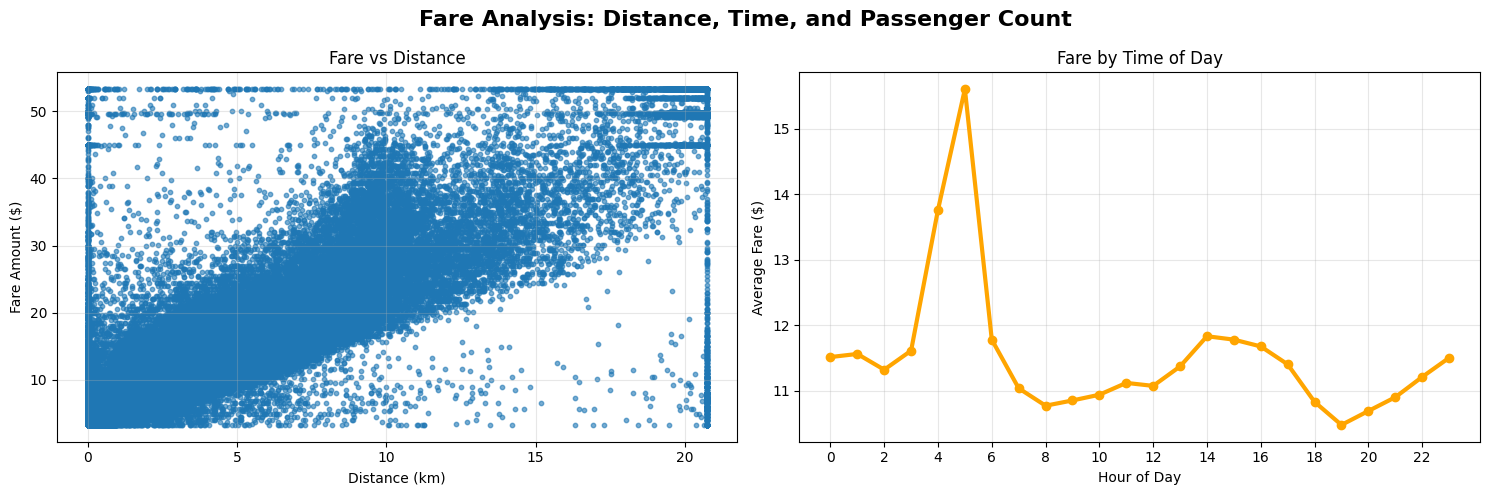

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Fare Analysis: Distance, Time, and Passenger Count', fontsize=16, fontweight='bold')

# Fare vs Distance
axes[0].scatter(df['haversine_distance'], df['fare_amount'], alpha=0.6, s=10)
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Fare Amount ($)')
axes[0].set_title('Fare vs Distance')
axes[0].grid(True, alpha=0.3)

# Fare by Time of Day
hourly_fare = df.groupby('pickup_hour')['fare_amount'].mean().reset_index()
axes[1].plot(hourly_fare['pickup_hour'], hourly_fare['fare_amount'], 
                marker='o', linewidth=3, color='orange', markersize=6)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Average Fare ($)')
axes[1].set_title('Fare by Time of Day')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

In [ ]:
# Additional detailed analysis
print("\n=== FARE VARIATION ANALYSIS ===")

# Correlation analysis
print("\n1. CORRELATION WITH DISTANCE:")
distance_corr = df[['fare_amount', 'haversine_distance']].corr().iloc[0,1]
print(f"Fare-Distance Correlation: {distance_corr:.3f}")

# Time-based analysis
print("\n2. FARE BY TIME PERIODS:")
df['time_period'] = pd.cut(df['pickup_hour'], 
                          bins=[0, 6, 12, 18, 24], 
                          labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                          include_lowest=True)
time_fare = df.groupby('time_period')['fare_amount'].agg(['mean', 'std', 'count'])
print(time_fare)

# Passenger count analysis
print("\n3. FARE BY PASSENGER COUNT:")
passenger_analysis = df.groupby('passenger_count').agg({
    'fare_amount': ['mean', 'std', 'count'],
    'haversine_distance': ['mean', 'std', 'count']
}).round(2)
print(passenger_analysis)

# Per-passenger fare
df['fare_per_passenger'] = df['fare_amount'] / df['passenger_count']
print("\n4. FARE PER PASSENGER:")
per_passenger_fare = df.groupby('passenger_count')['fare_per_passenger'].mean()
print(per_passenger_fare)

# Distance categories analysis
print("\n5. FARE BY DISTANCE CATEGORIES:")
df['distance_category'] = pd.cut(df['haversine_distance'], 
                                bins=[0, 2, 5, 10, float('inf')], 
                                labels=['Short (<2km)', 'Medium (2-5km)', 'Long (5-10km)', 'Very Long (>10km)'])
distance_fare = df.groupby('distance_category')['fare_amount'].agg(['mean', 'median', 'count'])
print(distance_fare)


=== FARE VARIATION ANALYSIS ===

1. CORRELATION WITH DISTANCE:
Fare-Distance Correlation: 0.844

2. FARE BY TIME PERIODS:
                  mean       std  count
time_period                            
Night        11.988305  9.460077  29901
Morning      10.965140  8.846408  53935
Afternoon    11.450096  9.676981  59530
Evening      10.927325  8.281019  56634

3. FARE BY PASSENGER COUNT:
                fare_amount               haversine_distance              
                       mean   std   count               mean   std   count
passenger_count                                                           
1                     11.13  8.93  139134               3.25  3.57  139134
2                     11.67  9.52   29428               3.44  3.82   29428
3                     11.38  9.14    8881               3.32  3.67    8881
4                     11.54  9.35    4276               3.36  3.74    4276
5                     11.15  8.94   14009               3.27  3.60   14009
6       

/tmp/ipykernel_6919/162941079.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_6919/162941079.py:37: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Pricing Insights
4. Is there dynamic pricing evidence? (fare/km variance by hour)
5. Are there fare anomalies or outliers to investigate?
6. How does passenger count affect per-passenger pricing?

## Operational Patterns
8. What's the geographic distribution of pickups?
9. Are there seasonal trends in ridership/fares?
10. Which trip categories (short/long) dominate?